<a href="https://colab.research.google.com/github/neemiasbsilva/mlops-with-tensorflow-extends/blob/main/notebooks/taxis_dataset_tfx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Corresponding TFX Libraries

## Instal Some Dependencies & Import Librarys 

In [1]:
!pip install -q -U \
  tensorflow==2.4.1 \
  tfx==0.28.0

In [ ]:
import os
import pprint
import numpy as np
import tempfile
import urllib

import absl
import pandas as pd
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate=False
pp = pprint.PrettyPrinter()

import tfx
from tfx.components import CsvExampleGen
from typing import Dict, List, Text
from tfx.components import Evaluator
from tfx.components import ExampleValidator
from tfx.components import Pusher
from tfx.components import ResolverNode
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Trainer
from tfx.components import Transform
from tfx.components.base import executor_spec
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.types import Channel
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing
from tfx.utils.dsl_utils import external_input


import seaborn as sns
import matplotlib.pyplot as plt


%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip
%matplotlib inline

In [6]:
def ensure_dir(directory: str):
    if (len(directory) > 0 and not os.path.exists(directory)):
        os.makedirs(directory)

In [7]:
tfx_path = "/content/tfx"
ensure_dir(tfx_path)
pipeline_path = os.path.join(tfx_path, "pipelines")
ensure_dir(pipeline_path)
metadata_path = os.path.join(tfx_path, "metadata")
ensure_dir(metadata_path)
logs_path = os.path.join(tfx_path, "logs")
ensure_dir(logs_path)
data_path = os.path.join(tfx_path, "data")
ensure_dir(data_path)
serving_model_path = os.path.join(tfx_path, "serving_model")
ensure_dir(serving_model_path)

## Download & Get Taxi Trip Dataset

In [9]:
data_path = "/content/data.csv"

In [8]:
!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv -q

In [10]:
df = pd.read_csv(data_path)

df.head()

,pickup_community_area,fare,trip_start_month,trip_start_hour,trip_start_day,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,pickup_census_tract,dropoff_census_tract,payment_type,company,trip_seconds,dropoff_community_area,tips
0,NaN,12.45,5,19,6,1400269500,NaN,NaN,NaN,NaN,0.0,NaN,NaN,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,0.0,NaN,0.0
1,NaN,0.00,3,19,5,1362683700,NaN,NaN,NaN,NaN,0.0,NaN,NaN,Unknown,Chicago Elite Cab Corp.,300.0,NaN,0.0
2,60.0,27.05,10,2,3,1380593700,41.836150,-87.648788,NaN,NaN,12.6,NaN,NaN,Cash,Taxi Affiliation Services,1380.0,NaN,0.0
3,10.0,5.85,10,1,2,1382319000,41.985015,-87.804532,NaN,NaN,0.0,NaN,NaN,Cash,Taxi Affiliation Services,180.0,NaN,0.0
4,14.0,16.65,5,7,5,1369897200,41.968069,-87.721559,NaN,NaN,0.0,NaN,NaN,Cash,Dispatch Taxi Affiliation,1080.0,NaN,0.0


## Data Wrabling

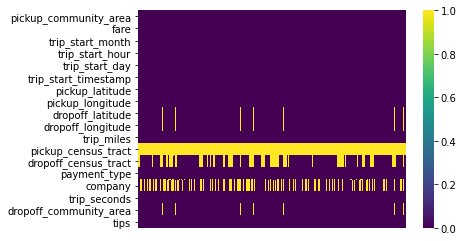

In [23]:
sns.heatmap(df.isnull().T, xticklabels=False, cmap="viridis")

In [24]:
df.isnull().sum()

pickup_community_area         2
fare                          0
trip_start_month              0
trip_start_hour               0
trip_start_day                0
trip_start_timestamp          0
pickup_latitude               2
pickup_longitude              2
dropoff_latitude            483
dropoff_longitude           483
trip_miles                    0
pickup_census_tract       15001
dropoff_census_tract       4241
payment_type                  0
company                    5140
trip_seconds                  6
dropoff_community_area      507
tips                          0
dtype: int64

In [26]:
df = df.drop(["trip_start_timestamp", "trip_miles", "pickup_census_tract",
              "dropoff_census_tract", "trip_seconds", "payment_type",
              "tips", "company", "dropoff_community_area", "pickup_community_area"], axis=1)

df = df.dropna()